In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

EPSILON = 1e-5

In [2]:
model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

In [3]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + EPSILON)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
def generate_pattern(layer_name, filter_index, size=150, steps=40):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[filter_index]
    grads /= (K.sqrt(K.mean(K.square(grads))) + EPSILON)

    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(steps):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

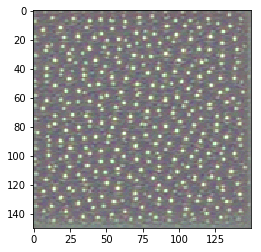

In [21]:
plt.imshow(generate_pattern(layer_name, filter_index))